# Customer Churn Notebook Simplified

In [87]:
# librairies loading 
import os

import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm #qq-plot
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# just to conserve what I want

import joblib
import yaml

# 1-) Data Inspection

In [3]:
os.getcwd()

'c:\\Users\\mayen\\ML_DL_PROJECTS\\Customer_Churn_prediction\\notebooks'

In [4]:
# dataset loading
notebooks_path = os.getcwd()
data_path = os.path.join(notebooks_path, "../data/raw_data/training.csv")

data_train = pd.read_csv(data_path, 
                        sep = ',',
                        header = 0)

print(data_train.shape)
data_train.head(10)

(11981, 19)


,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,C100000,zero,660.000000,19995.0,0,0,897338.0,False,4,3,160.0,155,1,1.2,15,very_unsat,little,considering,STAY
1,C100001,one,317.647059,31477.0,155,15,393396.0,True,0,1,100.0,245,27,2.7,4,unsat,little,considering,LEAVE
2,C100006,zero,208.695652,66742.0,0,13,937197.0,False,4,2,127.0,493,20,2.6,4,avg,very_little,considering,STAY
3,C100008,zero,265.017668,40864.0,183,0,986430.0,False,3,3,86.0,390,13,2.5,12,unsat,very_high,considering,LEAVE
4,C100010,one,440.000000,43321.5,200,0,394622.0,True,2,3,77.0,175,18,2.4,10,very_unsat,little,actively_looking_into_it,LEAVE
5,C100011,one,840.000000,18786.5,0,15,475819.0,True,1,2,143.0,187,0,3.8,4,very_unsat,very_high,actively_looking_into_it,STAY
6,C100012,zero,264.000000,46515.5,0,15,150498.0,True,3,1,191.0,363,1,3.2,4,very_unsat,very_high,never_thought,STAY
7,C100013,one,141.065831,90444.5,168,37,183605.0,True,5,3,217.0,539,28,2.0,2,very_sat,very_high,no,STAY
8,C100014,zero,483.870968,94779.5,179,0,677946.0,False,1,2,204.0,208,23,2.5,11,very_unsat,high,considering,LEAVE
9,C100015,one,276.315789,64602.5,204,24,270004.0,True,0,1,167.0,313,16,1.8,4,very_unsat,little,considering,STAY


In [5]:
# data structure
 
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CUSTOMER_ID                  11981 non-null  object 
 1   COLLEGE                      11981 non-null  object 
 2   DATA                         11981 non-null  float64
 3   INCOME                       11981 non-null  float64
 4   OVERCHARGE                   11981 non-null  int64  
 5   LEFTOVER                     11981 non-null  int64  
 6   HOUSE                        11346 non-null  float64
 7   LESSTHAN600k                 11346 non-null  object 
 8   CHILD                        11981 non-null  int64  
 9   JOB_CLASS                    11981 non-null  int64  
 10  REVENUE                      11981 non-null  float64
 11  HANDSET_PRICE                11981 non-null  int64  
 12  OVER_15MINS_CALLS_PER_MONTH  11981 non-null  int64  
 13  TIME_CLIENT     

In [4]:
pd.isnull(data_train).sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          635
LESSTHAN600k                   635
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
CHURNED                          0
dtype: int64

In [6]:
# features repartition

all_categorical_variables = [
 'COLLEGE',
 'LESSTHAN600k',
 'JOB_CLASS',
 'REPORTED_SATISFACTION',
 'REPORTED_USAGE_LEVEL',
 'CONSIDERING_CHANGE_OF_PLAN',
 'CHURNED']

numerical_variables = [
 'DATA',
 'INCOME',
 'OVERCHARGE',
 'LEFTOVER',
 'HOUSE',
 'CHILD',
 'REVENUE',
 'HANDSET_PRICE',
 'OVER_15MINS_CALLS_PER_MONTH',
 'TIME_CLIENT',
 'AVERAGE_CALL_DURATION']

# 2-) Visualization and preprocessing

## 2-1) Visualization

In [19]:
# catgoricals variables
categoricals_variables = [element for element in all_categorical_variables if element != "CHURNED"]

data_train["JOB_CLASS"] = data_train["JOB_CLASS"].astype("category")
for var in categoricals_variables :
        counts = data_train.groupby([var, 'CHURNED']).size().reset_index(name='count')
        total_per_college = counts.groupby(var)['count'].transform('sum')
        counts['percent'] = round(counts['count'] / total_per_college * 100, ndigits= 2)

        fig = px.histogram(counts,
                                x =  var,
                                y = "percent",
                                color = "CHURNED",
                                barmode= 'stack')

        fig.update_layout(title = f"{var} repartition by Churned",
                        #    template = "plotly_white",
                        width = 800,
                        height = 500
                        )
        fig.show()

C:\Users\mayen\AppData\Local\Temp\ipykernel_114872\3789155143.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\mayen\AppData\Local\Temp\ipykernel_114872\3789155143.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**Observations** : We notice that 

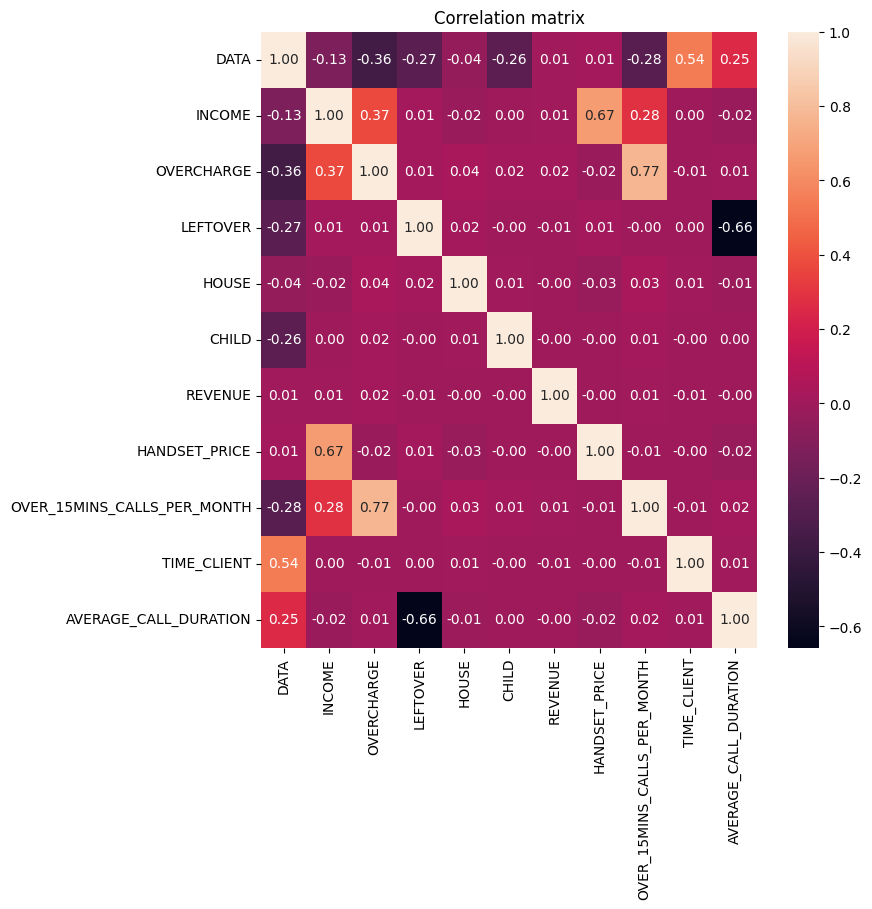

In [36]:
# quantitatives variables 
matrix = data_train[numerical_variables].corr()

plt.figure(figsize = (8,8))
sns.heatmap(matrix, annot = True, fmt = ".2f")
plt.title("Correlation matrix")
plt.show()

In [41]:
# numericals variables - density

for var in numerical_variables :

        fig = px.violin(data_train,
                                x =  var,
                                color = "CHURNED",
                                box= True
                                # points = 'all'
                                )

        fig.update_layout(title = f"{var} distribution by Churned",
                        #    template = "plotly_white",
                        width = 800,
                        height = 500
                        )
        fig.show()

## 2-2) Preprocessing

In [28]:
# categoricals variables - values transformation

data_train["COLLEGE"].replace({'zero': 0,
                               'one' : 1},
                               inplace = True)

data_train["LESSTHAN600k"].replace({False: 0,
                               True: 1},
                               inplace = True)

data_train["REPORTED_SATISFACTION"].replace({'very_unsat': 0,
                                             'unsat': 1,
                                             'avg' : 2,
                                             'sat': 3,
                                             'very_sat': 4},
                                             inplace = True)

data_train["REPORTED_USAGE_LEVEL"].replace({'very_little': 0,
                                             'little': 1,
                                             'avg' : 2,
                                             'high': 3,
                                             'very_high': 4},
                                             inplace = True)

data_train["CONSIDERING_CHANGE_OF_PLAN"].replace({'actively_looking_into_it': 0,
                                             'considering': 1,
                                             'perhaps' : 2,
                                             'no': 3,
                                             'never_thought': 4},
                                             inplace = True)
data_train["CHURNED"].replace({'STAY': 0,
                               'LEAVE' : 1},
                               inplace = True)


C:\Users\mayen\AppData\Local\Temp\ipykernel_114872\2649535452.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\mayen\AppData\Local\Temp\ipykernel_114872\2649535452.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\mayen\AppData\Local\Temp\ipykernel_114872\2649535452.py:7: Futu

In [42]:
# dataset division

features = data_train.drop(columns = ["CHURNED"], axis = 1)
target = data_train["CHURNED"]

data_train_2, data_val, y_train, y_val = train_test_split(features, target, test_size= 0.2, random_state = 42 )

print("data_train_2 : ",data_train_2.shape,"\ny_train: ",y_train.shape, 
      "\ndata_val : ", data_val.shape, "\ny_val : ",y_val.shape )

data_train_2 :  (9584, 18) 
y_train:  (9584,) 
data_val :  (2397, 18) 
y_val :  (2397,)


In [43]:
# missing values 1
impute = SimpleImputer(missing_values = np.nan, strategy= "most_frequent")

cat_train= impute.fit_transform(data_train_2[categoricals_variables])
cat_test = impute.transform(data_val[categoricals_variables])

cat_train = pd.DataFrame(cat_train, columns = categoricals_variables)
cat_test = pd.DataFrame(cat_test, columns = categoricals_variables)

for var in categoricals_variables :
    cat_train[var] = cat_train[var].astype("int")
    cat_test[var] = cat_test[var].astype("int")

In [44]:
# one hot encoding

encoder = OneHotEncoder()

cat_train2 = encoder.fit_transform(cat_train[["JOB_CLASS"]])
cat_test2= encoder.transform(cat_test[["JOB_CLASS"]])

variables = encoder.get_feature_names_out()
cat_train2 = pd.DataFrame(cat_train2.toarray(), columns =variables )
cat_test2 = pd.DataFrame(cat_test2.toarray(), columns =variables )

for var in variables :
    cat_train2[var] = cat_train2[var].astype("int")
    cat_test2[var] = cat_test2[var].astype("int")


In [45]:
# final categorical data
var2 = [var for var in categoricals_variables if var != "JOB_CLASS"]

cat_train_f = pd.concat([cat_train[var2], cat_train2], axis = 1)
cat_test_f = pd.concat([cat_test[var2], cat_test2], axis = 1)

# variables_bis = [var for var in categoricals_variables if var not in ['COLLEGE','LESSTHAN600k','JOB_CLASS']]
# categories_order = [0,1,2,3,4]

# for var in variables_bis:
#     cat_train_f[var] = pd.Categorical(cat_train_f[var], categories = categories_order, ordered = True)
#     cat_test_f[var] = pd.Categorical(cat_test_f[var], categories = categories_order, ordered = True)

In [85]:
# missing values 2 - numericals values
impute2 = SimpleImputer(missing_values = np.nan, strategy= "median")

quant_train= impute2.fit_transform(data_train_2[numerical_variables])
quant_test = impute2.transform(data_val[numerical_variables])

quant_train = pd.DataFrame(quant_train, columns = numerical_variables)
quant_test = pd.DataFrame(quant_test, columns = numerical_variables)


In [49]:
# standardardization

standard = StandardScaler()

quant_train2= standard.fit_transform(quant_train)
quant_test2 = standard.transform(quant_test)

quant_train2 = pd.DataFrame(quant_train2, columns = numerical_variables)
quant_test2 = pd.DataFrame(quant_test2, columns = numerical_variables)

In [91]:
# saving object that transform data

config_files_path = os.path.join(notebooks_path, "../config/config_files.yml" )

with open(config_files_path, 'r') as f :
    config = yaml.safe_load(f)

joblib.dump(impute, os.path.join(notebooks_path, config["files_path"]["imputer_cat"]))
joblib.dump(impute2, os.path.join(config["files_path"]["imputer_quant"]))
joblib.dump(encoder, os.path.join(config["files_path"]["encoder_path"]))
joblib.dump(standard, os.path.join(config["files_path"]["standardization"]))

['../src/models/standardisation.joblib']

In [51]:
# final dataset for ML

data_train_final = pd.concat([quant_train2, cat_train_f], axis = 1)
data_val_final = pd.concat([quant_test2, cat_test_f], axis = 1)

print(data_train_final.shape)
print(data_val_final.shape)
data_train_final.head()

(9584, 20)
(2397, 20)


,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,COLLEGE,LESSTHAN600k,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,JOB_CLASS_1,JOB_CLASS_2,JOB_CLASS_3,JOB_CLASS_4
0,-0.437726,-0.742722,-0.477153,-0.294297,-1.072248,0.740900,-0.747741,-0.447229,-0.409268,-0.642301,0.006459,0,1,2,4,4,0,0,1,0
1,-0.507454,2.113152,2.235611,-0.892328,-0.081995,1.541440,-0.685267,1.483809,0.725331,-1.064134,1.382167,1,1,2,3,1,1,0,0,0
2,-0.480289,-1.253986,-0.950998,-0.107412,1.888621,-0.059640,1.084807,-0.761141,-0.749647,-0.702563,-0.222825,1,0,0,1,1,0,0,0,1
3,-0.953138,-0.404764,1.655151,1.611928,1.976969,-0.860179,-0.935160,1.288803,1.633010,-0.823086,-0.910679,1,0,0,1,1,0,0,0,1
4,-0.810616,0.398469,1.406382,-0.892328,0.481629,1.541440,0.189358,-0.347347,1.633010,-1.064134,0.694313,1,0,4,4,1,1,0,0,0


# 3-) Machine learning

## 3-1) Model 1 : Logistic Regression

In [57]:
model_reg = LogisticRegression(class_weight = "balanced")

model_reg.fit(data_train_final, y_train)
y_pred = model_reg.predict(data_val_final)

In [56]:
data_train["CHURNED"].value_counts()

CHURNED
0    7612
1    4369
Name: count, dtype: int64

0.6879432624113475
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      1524
           1       0.56      0.68      0.61       873

    accuracy                           0.69      2397
   macro avg       0.68      0.69      0.68      2397
weighted avg       0.71      0.69      0.69      2397



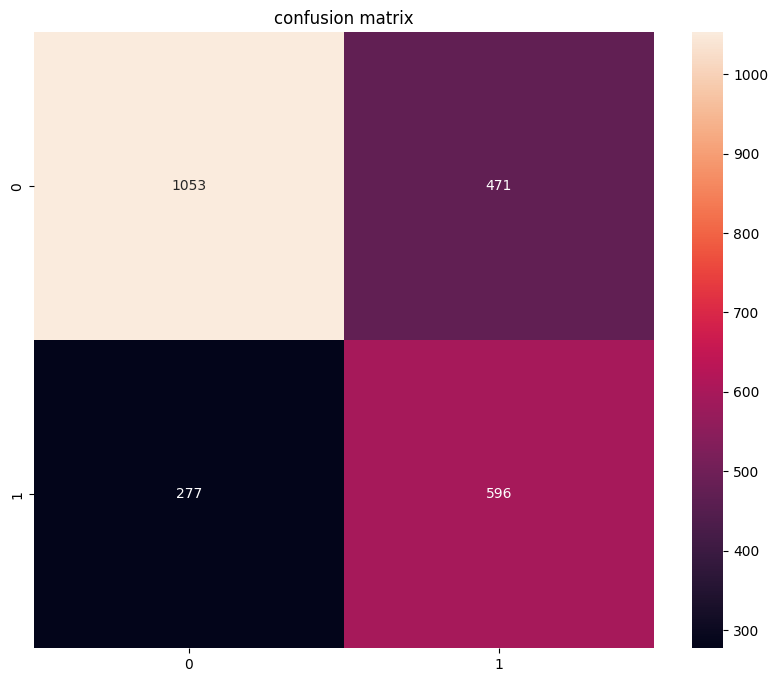

In [58]:
# model evaluation
print(accuracy_score(y_val, y_pred ))
print(classification_report(y_val, y_pred ))

matrice = confusion_matrix(y_val, y_pred )

plt.figure(figsize = (10,8))
sns.heatmap(matrice, annot = True, fmt = "d")
plt.title("confusion matrix")
plt.show()

## 3-2) Model 2 : Random Forest

In [61]:
# Entraînement model de Random Forest

rf_model = RandomForestClassifier(n_estimators = 1000, class_weight= 'balanced',random_state = 42)
rf_model.fit(data_train_final, y_train)

# predictions
y_pred_rf = rf_model.predict(data_val_final)

0.7726324572382144
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1524
           1       0.73      0.59      0.65       873

    accuracy                           0.77      2397
   macro avg       0.76      0.73      0.74      2397
weighted avg       0.77      0.77      0.77      2397



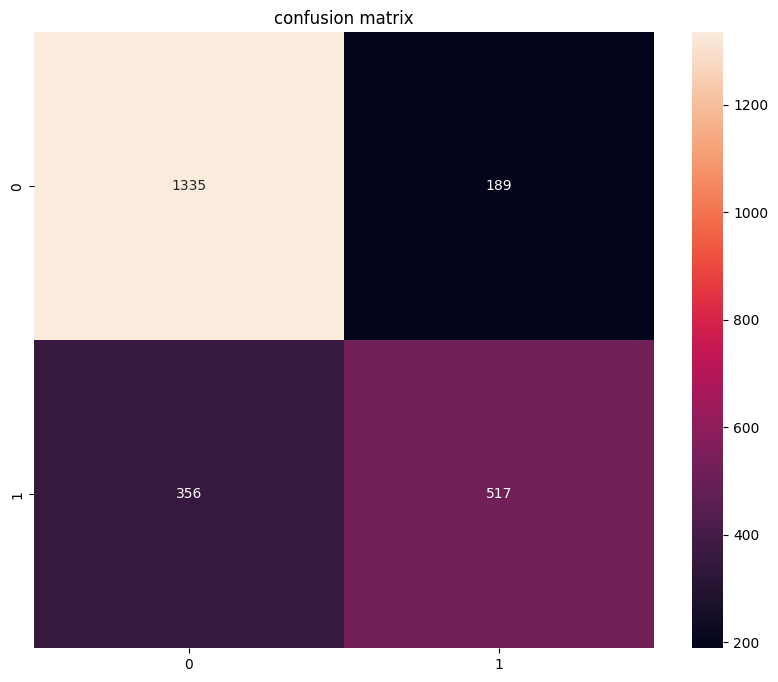

In [62]:
# Evaluation

print(accuracy_score(y_val, y_pred_rf ))
print(classification_report(y_val, y_pred_rf ))

matrice = confusion_matrix(y_val, y_pred_rf )

plt.figure(figsize = (10,8))
sns.heatmap(matrice, annot = True, fmt = "d")
plt.title("confusion matrix")
plt.show()

**Optimisation à l'aide de la GridSearchCV**

In [66]:
# GridSearchCV
rf_model2 = RandomForestClassifier(class_weight= "balanced", random_state= 42)

params_grid = {"n_estimators": [1000, 1500, 2000],
               "max_depth" : [5, 10, 15],
               "max_features": [3,5,10]}

cv = StratifiedKFold(n_splits = 5,random_state = 42)

model_rf_grid = GridSearchCV(estimator= rf_model2, param_grid= params_grid, scoring= "roc_auc", cv = cv )
model_rf_grid.fit(data_train_final, y_train)

y_pred_rf2 = model_rf_grid.predict(data_val_final)

In [67]:
# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", model_rf_grid.best_params_)

# Afficher la meilleure performance (AUC)
print("Meilleure performance (AUC) :", model_rf_grid.best_score_)

Meilleurs hyperparamètres : {'max_depth': 15, 'max_features': 10, 'n_estimators': 2000}
Meilleure performance (AUC) : 0.8415809330235714


0.7684605757196495
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1524
           1       0.70      0.65      0.67       873

    accuracy                           0.77      2397
   macro avg       0.75      0.74      0.75      2397
weighted avg       0.77      0.77      0.77      2397



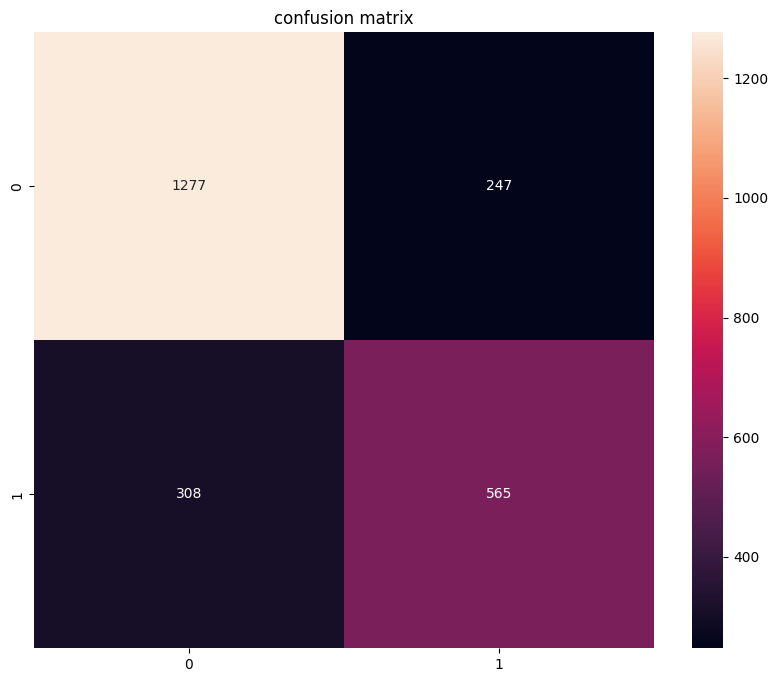

In [68]:
# Evaluation

print(accuracy_score(y_val, y_pred_rf2 ))
print(classification_report(y_val, y_pred_rf2 ))

matrice = confusion_matrix(y_val, y_pred_rf2 )

plt.figure(figsize = (10,8))
sns.heatmap(matrice, annot = True, fmt = "d")
plt.title("confusion matrix")
plt.show()

In [70]:
print(len(data_train_final.columns.to_list()))
print(len(model_rf_grid.best_estimator_))



20
2000


In [72]:
model_rf_grid.best_estimator_.feature_importances_

array([0.12967498, 0.10792961, 0.10123486, 0.07144128, 0.10875253,
       0.0255325 , 0.05790588, 0.07584362, 0.04795254, 0.0738751 ,
       0.0354477 , 0.00804446, 0.02318416, 0.06410324, 0.01885487,
       0.02575359, 0.00611773, 0.00607754, 0.00597131, 0.00630251])

In [75]:
# features importances

importances_df = pd.DataFrame({"features" : data_train_final.columns.to_list(),
                               "importances" : model_rf_grid.best_estimator_.feature_importances_}).sort_values(by = "importances", ascending = True)

fig = px.histogram(importances_df,
             x ="importances",
             y= "features")

fig.update_layout(title = "Features Importances",
                  width = 800,
                  height = 500)

fig.show()

## 3-3 ) Model 3 : XGBoost

In [79]:
data_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9584 entries, 0 to 9583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   DATA                         9584 non-null   float64 
 1   INCOME                       9584 non-null   float64 
 2   OVERCHARGE                   9584 non-null   float64 
 3   LEFTOVER                     9584 non-null   float64 
 4   HOUSE                        9584 non-null   float64 
 5   CHILD                        9584 non-null   float64 
 6   REVENUE                      9584 non-null   float64 
 7   HANDSET_PRICE                9584 non-null   float64 
 8   OVER_15MINS_CALLS_PER_MONTH  9584 non-null   float64 
 9   TIME_CLIENT                  9584 non-null   float64 
 10  AVERAGE_CALL_DURATION        9584 non-null   float64 
 11  COLLEGE                      9584 non-null   int64   
 12  LESSTHAN600k                 9584 non-null   int64   
 13  REP

In [ ]:
# save bjects transforming data


In [80]:
# first model
for var in [ 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN'] :
    data_train_final[var] = data_train_final[var].astype('int')
    data_val_final[var] = data_val_final[var].astype('int')

xgb_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 42)
xgb_model.fit(data_train_final, y_train)

y_pred_xg = xgb_model.predict(data_val_final)

c:\Users\mayen\ML_DL_PROJECTS\Customer_Churn_prediction\customer_churn\Lib\site-packages\xgboost\training.py:183: UserWarning:

[18:26:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




0.7834793491864831
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1524
           1       0.72      0.66      0.69       873

    accuracy                           0.78      2397
   macro avg       0.77      0.76      0.76      2397
weighted avg       0.78      0.78      0.78      2397



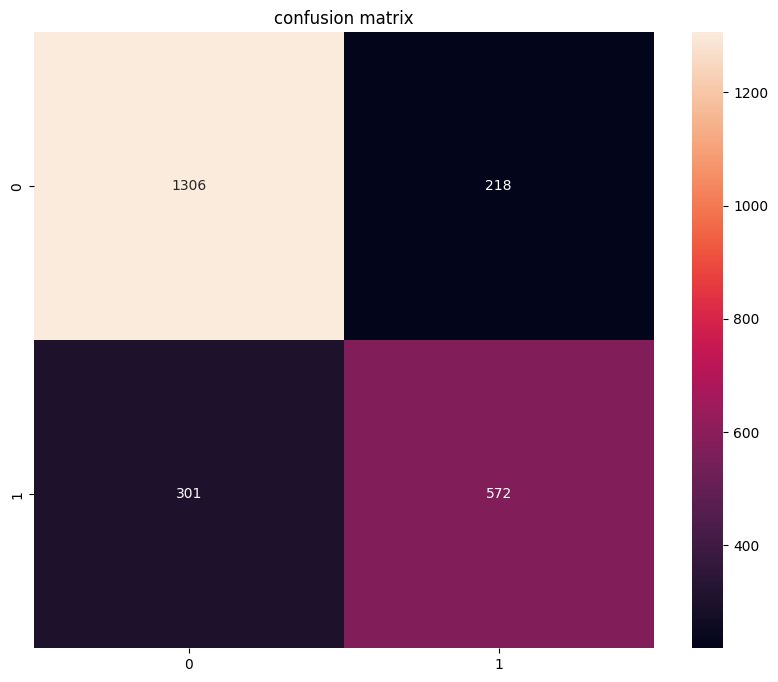

In [81]:
# Evaluation

print(accuracy_score(y_val, y_pred_xg ))
print(classification_report(y_val, y_pred_xg ))

matrice = confusion_matrix(y_val, y_pred_xg )

plt.figure(figsize = (10,8))
sns.heatmap(matrice, annot = True, fmt = "d")
plt.title("confusion matrix")
plt.show()

In [94]:
# model saving
joblib.dump(xgb_model, os.path.join(config["files_path"]["model_path"]))

['../src/models/xg_boost_model.joblib']

## 3-4) Model 4 : LGBM

In [82]:
# first model

lgbm_model = LGBMClassifier(random_state = 42)

lgbm_model.fit(data_train_final, y_train)
y_pred_lgbm = lgbm_model.predict(data_val_final)

[LightGBM] [Info] Number of positive: 3496, number of negative: 6088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 9584, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.364775 -> initscore=-0.554700
[LightGBM] [Info] Start training from score -0.554700


0.7684605757196495
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1524
           1       0.70      0.65      0.67       873

    accuracy                           0.77      2397
   macro avg       0.75      0.74      0.75      2397
weighted avg       0.77      0.77      0.77      2397



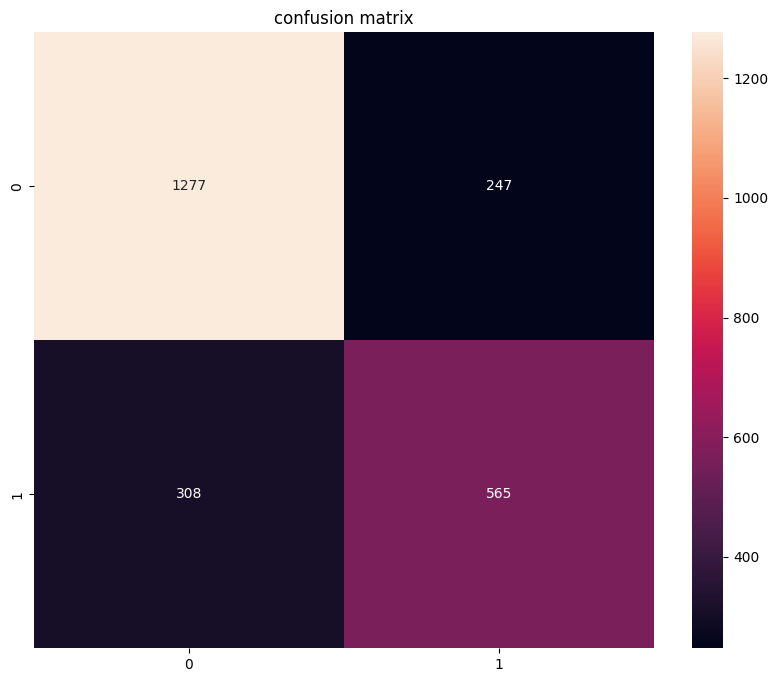

In [83]:
# Evaluation

print(accuracy_score(y_val, y_pred_rf2 ))
print(classification_report(y_val, y_pred_rf2 ))

matrice = confusion_matrix(y_val, y_pred_rf2 )

plt.figure(figsize = (10,8))
sns.heatmap(matrice, annot = True, fmt = "d")
plt.title("confusion matrix")
plt.show()